In [1]:
import os
import re
from collections import Counter
import string
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...


In [2]:
coronaTweets = pd.read_csv('../00_source_data/CoronaTweet.csv', encoding='latin-1')
coronaTweets.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
# collapse sentiment to 3 categories
coronaTweets['Sentiment'] = coronaTweets['Sentiment'].map({'Extremely Negative': 'Negative', 'Negative': 'Negative', 'Neutral': 'Neutral', 'Positive': 'Positive', 'Extremely Positive': 'Positive'})

In [4]:
coronaTweets['Sentiment'].value_counts()

Positive    18046
Negative    15398
Neutral      7713
Name: Sentiment, dtype: int64

## Preprocessing

convert to lower\
remove http link\
remove hashtag\
remove emoji\
remove stopwords\
remove punctuations\
Stemmer\
WordVectorize

In [5]:
# define preprocessing function
def preprocess(text):

    # lowercase
    text = text.lower()
    # remove http links
    text = re.sub(r'http\S+', '', text)
    # remove hashtags
    text = re.sub(r'#\S+', '', text)
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # only contain lowercaser 
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # remove stopwords
    text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])
    # Stemming
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])

    return text

In [6]:
coronaTweets['text'] = coronaTweets['OriginalTweet'].apply(preprocess)
coronaTweets.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,menyrbi philgahan chrisitv
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advic talk neighbour famili exchang phone numb...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronaviru australia woolworth give elderli di...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,food stock one empti pleas dont panic enough f...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative,readi go supermarket outbreak im paranoid food...


### Train Naive Bayes Classifier

In [7]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(coronaTweets['text'], coronaTweets['Sentiment'], test_size=0.3, random_state=42)

In [8]:
# CounterVectizor
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

# training classifier with NB
nb = MultinomialNB()
nb.fit(X_train_cv, y_train)

# print prediction and metrics on training set
y_pred_tr = nb.predict(X_train_cv)
print('Training set')
print('Accuracy: ', accuracy_score(y_train, y_pred_tr))
print('Confusion Matrix: ', confusion_matrix(y_train, y_pred_tr))
print('Classification Report: ', classification_report(y_train, y_pred_tr))
print('=====================================')

# print prediction and metrics on test set
y_pred_te = nb.predict(X_test_cv)
print('Test set')
print('Accuracy: ', accuracy_score(y_test, y_pred_te))
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred_te))
print('Classification Report: ', classification_report(y_test, y_pred_te))


Training set
Accuracy:  0.7924606893679058
Confusion Matrix:  [[ 9303   115  1403]
 [ 1230  2286  1905]
 [ 1195   131 11241]]
Classification Report:                precision    recall  f1-score   support

    Negative       0.79      0.86      0.83     10821
     Neutral       0.90      0.42      0.57      5421
    Positive       0.77      0.89      0.83     12567

    accuracy                           0.79     28809
   macro avg       0.82      0.73      0.74     28809
weighted avg       0.80      0.79      0.78     28809

Test set
Accuracy:  0.6781665046971169
Confusion Matrix:  [[3467   65 1045]
 [ 731  408 1153]
 [ 900   80 4499]]
Classification Report:                precision    recall  f1-score   support

    Negative       0.68      0.76      0.72      4577
     Neutral       0.74      0.18      0.29      2292
    Positive       0.67      0.82      0.74      5479

    accuracy                           0.68     12348
   macro avg       0.70      0.59      0.58     12348
weight

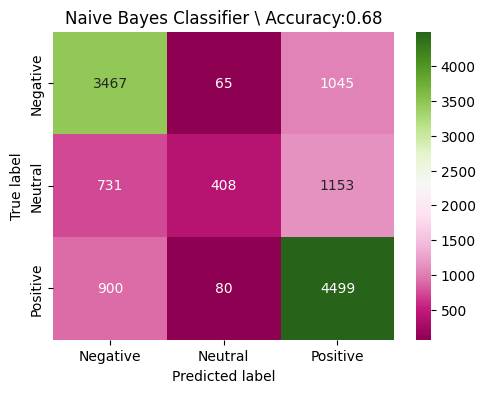

In [9]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred_te)
cm_df = pd.DataFrame(cm, index=['Negative', 'Neutral', 'Positive'], columns=['Negative', 'Neutral', 'Positive'])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt='g', cmap="PiYG")
plt.title('Naive Bayes Classifier \ Accuracy:{0:.2f}'.format(accuracy_score(y_test, y_pred_te)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

# save plot to file
plt.savefig('../30_results/NB_real_data.png')